# Classificação Numérica - Rede Neural

In [1]:
# instalando bibliotecas
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
# importando bibliotecas
import numpy as np
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt 
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

## Convertendo dados - Tensor

Tensor é como uma matriz, mas não existe um limite de dimensões, podendo estar entre 0 a n. A biblioteca transforma os dados em tensor, por isso iremos realizar a transformação

In [3]:

import torch
from torchvision import datasets, transforms
# definindo a imagem para tensor
transform = transforms.ToTensor()

# treino do dataset
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
# pegar os dados por parte
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# teste do dataset
testset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
# pegar os dados por parte
vallloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Conferindo dados

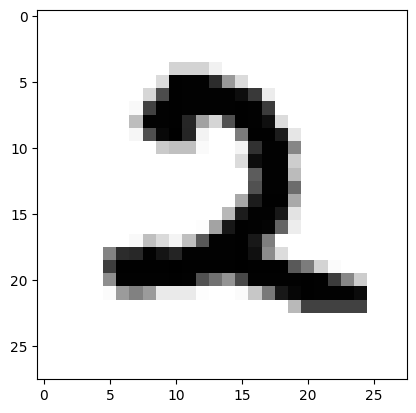

In [4]:
# abrir um dos itens do dataset para visualizar formato
dataiter = iter(trainloader)
img, target = next(dataiter)
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r')


In [5]:
# analisando a dimensao do tensor imagem e tensor etiqueta
# 1 = intensidade do preto em cada pixel
# 28 = altura da imagem
# 28 = largura da imagem
print(img[0].shape)

# etique nao possui dimensao por ser um escalar
print(target[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


## Adicionando elementos da RN

Usaremos 3 funções de ativação: ReLU, ReLU e SoftMax

In [6]:
class Modelo(nn.Module):
    def __init__(self): 
        super(Modelo, self).__init__()
        ## camada de entrada, 784 neurônios que se ligam a 128
        self.linear1 = nn.Linear(784, 128)
        ## camada oculta 1, 128 neurônios que se ligam a 64
        self.linear2 = nn.Linear(128, 64)
        ## camada oculta 2, 64 neurônios que se ligam a 10
        self.linear3 = nn.Linear(64, 10)

        # nao definimos a camada de saida pois pegamos ela a partir da camada 2

    def forward(self, X):
        # camada de entrada 
        X = F.relu(self.linear1(X))
        # camada oculta 1
        X = F.relu(self.linear2(X))
        # camada oculta 2
        X = self.linear3(X)
        # camada de saida
        return F.log_softmax(X, dim=1)


## Estrutura de treino do modelo

- Calcular a perda a partir da comparação entre as predições e as etiquetas(target) do subgrupo sendo analisado
- Com a perda, calcular o gradiente em relação aos pesos e as bias
- A partir do gradiente e de uma politica de otimização, atualizar os pesos e as bias 

### Otimizador

A partir do optim é possível escolher qual otimizador usar para fazer as atualizações dos pesos e do bias.

In [7]:
# definindo funcao treino
# interacao trainloader, back propagation e otimizador step sao repetidos ate que todo trainset seja percorrido   
def treino(modelo, trainloader, device):
    # definindo a funcao de perda e o otimizador do peso e do bias
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
    inicio = time()

# definindo criterio para calcular a perda
    criterio = nn.NLLLoss()
    # numero de EPOCHS para treinar
    EPOCHS = 30
    # ativando treinamento do modelo
    modelo.train()

    for epoch in range(EPOCHS):
        perda_acumulada = 0

        for img, target in trainloader:
            # convertendo as img para "vetores" 28*28 para serem compativeis com a entrada
            img = img.view(img.shape[0], -1)
            # zerando o gradiente para o proximo ciclo
            otimizador.zero_grad()

            # colocanndo os dados no modelo
            output = modelo(img.to(device))
            #calculando a perda da epoch atual
            perda_instantanea = criterio(output, target.to(device))

            # back propagation a partir da perda da epoch atual
            perda_instantanea.backward()
            # atualizando pesos e bias
            otimizador.step()
            #atualizacao da perda acumulada
            perda_acumulada += perda_instantanea.item()
        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
            print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

In [8]:
# funcão de otimizacao do modelo para teste
def validacao(modelo, valloader, device):
    contas_corretas, conta_todas = 0, 0
    for img, target in valloader:
        for i in range(len(target)):
            imgs = img[i].view(1, 784)
            # desativer autograd. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                # saida do modelo em escala logaritmica
                logps = modelo(imgs.to(device))

            # converte saida escala normal (tensor)
            ps = torch.exp(logps)   
            # probabilidade de cada classe
            probab = list(ps.cpu().numpy()[0])
            # converte o tensor em numero,  o numero que previu correto
            pred_label = probab.index(max(probab))
            pred_certa = target.numpy()[i]
            # compara se o numero previsto é igual ao numero real
            if(pred_certa  == pred_label):
                contas_corretas += 1
            conta_todas += 1

    print("Numero de imagens testadas =", conta_todas)
    print("\nNumero de imagens previstas corretamente =", contas_corretas)
    print("\nAcuracia do modelo =", (contas_corretas*100)/conta_todas, "%")

## Rodando Rede Neural

In [9]:
# inicializando o modelo
modelo = Modelo()
# definindo o dispositivo de processamento
# modelo rodara na GPU se possivel, caso contrario, rodara na CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
# treinando o modelo
treino(modelo, trainloader, device)

Epoch 1 - Perda resultante: 1.1826049812567005

Tempo de treino (em minutos) = 0.12862290938695273
Epoch 2 - Perda resultante: 0.37916405227329175

Tempo de treino (em minutos) = 0.25092164278030393
Epoch 3 - Perda resultante: 0.3120970111697722

Tempo de treino (em minutos) = 0.3732879718144735
Epoch 4 - Perda resultante: 0.2745448732530194

Tempo de treino (em minutos) = 0.5090359012285869
Epoch 5 - Perda resultante: 0.2454791111764369

Tempo de treino (em minutos) = 0.6442544976870219
Epoch 6 - Perda resultante: 0.2198330759644699

Tempo de treino (em minutos) = 0.7697880427042644
Epoch 7 - Perda resultante: 0.1981136041647717

Tempo de treino (em minutos) = 0.8956608176231384
Epoch 8 - Perda resultante: 0.17934395360555858

Tempo de treino (em minutos) = 1.0229680101076761
Epoch 9 - Perda resultante: 0.1632647673859557

Tempo de treino (em minutos) = 1.1463393449783326
Epoch 10 - Perda resultante: 0.14947747221705057

Tempo de treino (em minutos) = 1.2711917718251546
Epoch 11 - Per

In [11]:
# validando o modelo
validacao(modelo, vallloader, device)



Numero de imagens testadas = 10000

Numero de imagens previstas corretamente = 9749

Acuracia do modelo = 97.49 %


### Visualizar uma predição aleatória

In [13]:
def visualiza_pred(img, ps):

    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Palpite')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Número previsto = 0


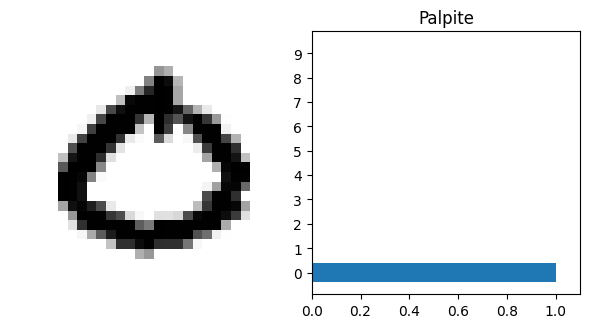

In [31]:
# Carrega um lote de imagens e etiquetas do conjunto de dados de treinamento
imagens, etiquetas = next(iter(trainloader))
# Seleciona a primeira imagem do lote e a redimensiona para um vetor de 784 elementos
img = imagens[0].view(1, 784)
# Desativa o cálculo do gradiente para acelerar a inferência
with torch.no_grad():
    # Passa a imagem pelo modelo e obtém os logaritmos das probabilidades das classes
    logps = modelo(img.to(device))

# Calcula as probabilidades das classes aplicando a função exponencial aos logaritmos
ps = torch.exp(logps)
# Converte as probabilidades em uma lista e encontra o índice da classe com maior probabilidade
probab = list(ps.cpu().numpy()[0])
print("Número previsto =", probab.index(max(probab)))

# Mostra a imagem e o gráfico de barras das probabilidades das classes
visualiza_pred(img.view(1, 28, 28), ps)



## Salvando modelo

In [32]:
# para salvar o modelo
torch.save(modelo.state_dict(), './primeiro_modelo.pt')

# para carregar o modelo
modelo_carregado = Modelo()

modelo_carregado.load_state_dict(torch.load('./primeiro_modelo.pt'))
modelo_carregado.eval()
modelo_carregado.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)